In [2]:
import pandas as pd
import sklearn
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn import decomposition
import numpy as np
from numpy import log10, linspace, array, log2, zeros, append, std, asarray, vstack
import matplotlib.pyplot as plt
from math import log
import sympy as sp
from sympy import symbols, simplify, Function, diff, latex, sqrt, solve
sp.init_printing(use_latex='mathjax')
from IPython.display import display, Math
from scipy.integrate import solve_ivp, odeint
from scipy.optimize import minimize
from math import log

## Question 1

#### Variables

In [3]:
t_     = symbols('t',     positive=True)               # time                                   (s)
ro_    = symbols('\\rho', positive=True)               # liquid density                         (kg/m^3)
l_     = symbols('l',     positive=True)               # valve stem position                    (1 == fully open)
A_     = symbols('A',     positive=True)               # tank cross sectional area              (m^2)
g_     = symbols('g',     positive=True)               # gravitational constant                 (m/s^2)
 
qi_    = Function('\\textit{q}_i', real=True)(t_)      # inlet flowrate                         (m^3/s)
qo_    = Function('\\textit{q}_o', real=True)(t_)      # outlet flowrate                        (m^3/s)
h_     = Function('\\textit{h}',   real=True)(t_)      # liquid level                           (m)
P_     = Function('P',             real=True)(t_)      # guage pressure in tank at valve level  (kPa) 
delP_  = Function('\\rho g h',     real=True)(t_)      # guage pressure equation                (kPa)
 
dhdt_  = h_.diff(t_)

#### Assuming constant liquid density and tank cross sectional area
#### The mass balance becomes:

In [4]:
display(Math('A'+latex(dhdt_)+' = '+latex(qi_ - qo_)))

<IPython.core.display.Math object>

#### With the outlet at the bottom of the tank, the guage pressure at the bottom of the tank:

In [5]:
display(Math(latex(P_)+' = '+'\\rho'+' g'+latex(h_)))

<IPython.core.display.Math object>

#### Assume for convenience the following valve equation:

In [6]:
display(Math(latex(qo_)+' = '+latex(l_*sqrt(P_))))

<IPython.core.display.Math object>

#### Substitution yields:

In [7]:
display(Math('A'+latex(dhdt_)+' = '+latex(qi_)+' - '+latex(l_)+latex(sqrt(delP_))))

<IPython.core.display.Math object>

#### The steady state liquid level in the tank when $q_{i}(t) = 1$, $A = 1$, $l = 0.5$ and $\rho = 1$

In [8]:
h_ss = solve(1 - 0.5*sqrt(10*h_), h_)[0]
h_ss

0.400000000000000

#### Simulating a step change of in $q_{i}(t)$ of +1 at $t = 0$ and a step change in $l$ of +0.5 at $t = 100$ 

In [9]:
qi_ss = 1
l_ss = 0.5
h_ss = 0.4

def DE(h, t):
    
    qi = 1         # step at t = 0
    
    if t >= 15:    # step at t = 15
        l = 0.5
    else:
        l = 0
    
    if h <= 0:
        h = 0.0001
        
    dhdt = qi + qi_ss - (l + l_ss)*(10*(h + h_ss))**0.5           # in deviation variables
    
    return dhdt

In [10]:
tsp = linspace(0, 20, 201)
ht = odeint(DE, 0, tsp, hmax=0.001)

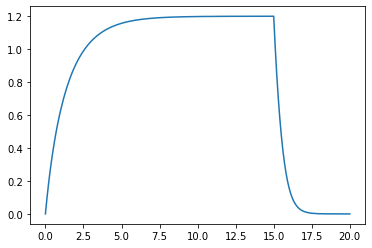

In [11]:
plt.plot(tsp, ht)
plt.show()

## Question 2

#### This function generates random measurements and aplies a Kalman filter:

In [131]:
def KalmanSim(ts, EST, Meas_mean, Meas_SD, E_est, max_val=10**10, min_val=0):  # (time space, initial guess of estimate, mean of the measurements, standard deviation of the measurements, initial guess of estimate error, max value of the measurements, min value of the measurements)
    
    ESTs = array([])
    Meass = array([])
    
    for t in ts:
        
        Meas = np.random.normal(loc=Meas_mean, scale=Meas_SD)
        
        if Meas > max_val:
            Meas = max_val
        if Meas < min_val:
            Meas = 0

        E_meas = Meas_SD 

        KG    = E_est/(E_est + E_meas)
        E_est = (1 - KG)*E_est
        EST  += KG*(Meas - EST)
        
        ESTs = append(ESTs, EST)
        Meass = append(Meass, Meas)
        
        # accuracy is measured simply as the ratio of the average errors
        
        accuracy = (sum(abs(Meass - Meas_mean))/len(Meass))/(sum(abs(ESTs - Meas_mean))/len(ESTs))
        
    return array([ESTs, Meass, [accuracy]])


#### Simulating the above Kalman filter:

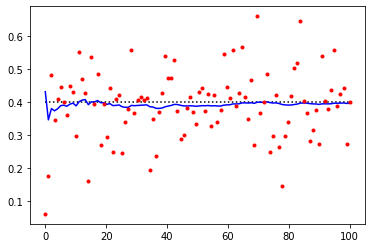

'8.2 times more accurate'

In [13]:
tsp2 = linspace(0, 100, 100)
Meas_mean_ = 0.4
EST_ = 2*Meas_mean_
Meas_SD_ = 0.1
E_est_ = 0.1

y = KalmanSim(tsp2, EST_, Meas_mean_, Meas_SD_, E_est_)
plt.plot(tsp2, zeros(shape=(1, len(tsp2)))[0]+Meas_mean_, ':', color='black')
plt.plot(tsp2, y[0], color='blue')
plt.plot(tsp2, y[1], '.', color='red')
plt.show()
display('{0} times more accurate'.format(round(y[2][0], 1)))

### Question 3

#### Generating data of a disturbance:

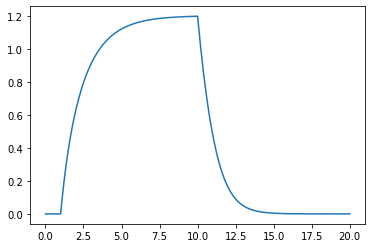

In [134]:
qi_ss = 1
l_ss = 0.5
h_ss = 0.4
l = 0

def DE(h, t):
    
    if 1 <= t <= 10:    # step at t = 100
        qi = 1
    else:
        qi = 0
    
    if h <= 0:
        h = 0.0001
        
    dhdt = qi + qi_ss - (l + l_ss)*(10*(h + h_ss))**0.5
    
    return dhdt

tsp = linspace(0, 20, 201)
ht = odeint(DE, 0, tsp, hmax=0.001)
plt.plot(tsp, ht)
plt.show()

### fitting the model:

In [136]:
def fit_param(u_data, y_data, trunc=0.01):  # trunc = the fraction by which output has stabilised
    
    i = 0
    peaked = 0
    past = 0
    bi = array([])
    
    while(abs(y_data[i]/max(y_data)) >= trunc or peaked == 0):
        
        if y_data[i] == max(y_data):
            peaked = 1
        i += 1
        
        if u_data[i] == 0:
            b = 0
        else:
            b = (y_data[i] - past)/u_data[i]
        
        bi = append(bi, b)
        past += b*u_data[i]
        
    return bi

#### The input data used to get the data:

In [140]:
u = zeros(shape=(1, len(tsp)))[0]

for i, t in enumerate(tsp):
    
    if 1 <= t <= 10:    # step at t = 100
        qi = 1
    else:
        qi = 0
        
    u[i] = qi

In [141]:
bb = fit_param(u, ht)

#### Making a new set of input data

In [142]:
u = zeros(shape=(1, len(tsp)))[0]

for i, t in enumerate(tsp):
    
    if 1 <= t <= 5: 
        qi = 0.5
    else:
        qi = 0
        
    u[i] = qi

#### generating the function values from the model

In [143]:
y = 0
yi = array([])

for i in range(len(bb)):
    ii = int(i+1)

    y += bb[i]*u[i]
    yi = append(yi, y)
    
    if u[int(ii - 1)] != 0 and u[ii] == 0:
        break
    

#### Generating the 'real' response from the new input data

In [144]:
qi_ss = 1
l_ss = 0.5
h_ss = 0.4
l = 0

def DE(h, t):
    
    if 1 <= t <= 5:    # step at t = 100
        qi = 0.5
    else:
        qi = 0
    
    if h <= 0:
        h = 0.0001
        
    dhdt = qi + qi_ss - (l + l_ss)*(10*(h + h_ss))**0.5
    
    return dhdt

In [145]:
tsp = linspace(0, 20, 201)
ht = odeint(DE, 0, tsp, hmax=0.001)

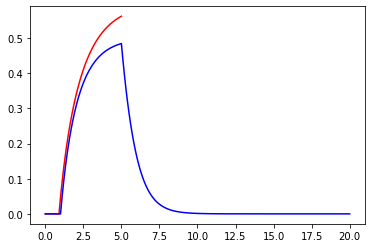

In [146]:
tsp2 = tsp[0:len(yi)]
u2 = u[0:len(yi)]
plt.plot(tsp2, yi, color='red')
plt.plot(tsp, ht, color='blue')
plt.show()

### Clasification

In [26]:
cd = pd.read_csv('ClassificationDataset.csv')
cd

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,Class
0,2.375389,-0.095413,-1.404611,-3.316901,1.292636,1.314285,-2.144697,-1.786964,-0.433559,1.599777,A
1,0.218283,-4.220461,-2.755807,2.984006,-1.124723,1.354546,0.434317,1.950082,0.521801,1.421198,A
2,2.446752,3.141548,0.682045,-2.150649,0.748225,0.680665,-1.226283,-0.128732,0.402510,1.202543,B
3,0.274446,4.022857,-0.947952,-3.340053,4.007577,1.764534,0.356049,-0.833979,-0.092982,-0.025736,B
4,-0.492815,3.394374,1.377276,-1.178074,1.844517,-0.600862,-0.162713,-2.162985,0.117962,-2.190834,B
...,...,...,...,...,...,...,...,...,...,...,...
995,-0.999790,5.314545,1.800354,-3.152876,1.732943,-1.523077,-1.184342,-2.899511,-0.444180,-1.744732,B
996,-2.041887,-0.088785,-0.169866,3.865043,-2.536561,1.217006,0.287671,1.526600,0.460804,0.291991,A
997,2.673603,-1.594662,-4.008045,2.256176,-1.209324,-0.080157,-0.056809,1.560895,0.556794,1.020146,A
998,1.839575,-2.160172,-1.873964,2.536802,-0.135922,1.286275,-0.191015,0.867695,0.495838,3.087940,A


In [27]:
features = array(cd.drop(columns=['Class']))
datums = array(cd['Class'])
features_std = StandardScaler().fit_transform(features)

#### To visulise the data, the eigen values are calculated to see which input set has the strongest effect on the output

In [28]:
covariance_matrix = np.cov(features_std.T)
eig_vals, eig_vecs = np.linalg.eig(covariance_matrix)
eig_vals

array([4.33084825, 2.28631901, 0.96120868, 0.73635887, 0.56866703,
       0.10770955, 0.18768506, 0.23608299, 0.30900326, 0.28612732])

#### Sets X1 and X2 have the strongest effect

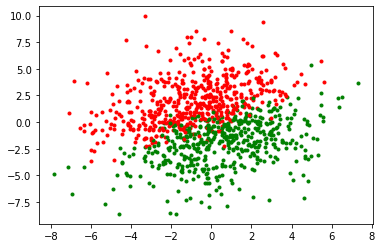

In [150]:
for i in range(len(datums)):
    
    if datums[i] == 'A':
        plt.plot(features[i, 0], features[i, 1], '.', color='green')
    elif datums[i] == 'B':
        plt.plot(features[i, 0], features[i, 1], '.', color='red')

plt.show()

#### Writing a general clasification algorithm (arbitrary amount of features and datums):
The tradeoff between size and accurance can be made with 'split_resolution' in the function input, which is the amount od times a data set is split per node in search of the best split point. Also, E_tol can be used which is the maximum allowable entropy of a decicion node 

In [166]:
class Classifier():
    def __init__(self, Features, Datums, split_resolution=201, E_tol=0.001):
        
        diff_datums = array([Datums[0]])
        for i, d in enumerate(Datums):
            new_datum = 1
            for j in diff_datums:
                if Datums[i] == j:
                    new_datum = 0
            if new_datum == 1:
                diff_datums = append(diff_datums, d)
        
        no_datums = len(diff_datums)
        
        datums_as_numbers = zeros(shape=(1, len(Datums)))[0]
        
        for j, d in enumerate(diff_datums):
            for i, D in enumerate(Datums):
                no = int(j+1)
                if d == D:
                    datums_as_numbers[i] = no
                
        
        self.Features = Features
        self.Datums = Datums
        self.diff_datums = diff_datums
        self.no_datums = no_datums
        self.datums_as_numbers = datums_as_numbers
        self.split_resolution = split_resolution
        self.E_tol = E_tol
        
        no_features = len(Features[0, :])
        self.no_features = no_features
        
        features_dict = {}
        for ii in range(no_features):
            i = int(ii+1)
            features_dict['X{0}'.format(i)] = list(Features[:, ii])
            
        self.features_dict = features_dict
        
        Tree = {'L0': {'N1': {'status': 'leaf', 'fd': features_dict, 'dd': list(Datums)}}}
        tree = {'L0': {'N1': 'leaf'}}
        self.Tree = Tree
        self.tree = tree
        
        self.buildTree = self.build_tree()[1]
        
    def predominent_datum(self, dist):
        for ii, d in enumerate(dist):
            i = int(ii+1)
            if max(dist) == d:
                for j, datum in enumerate(self.Datums):
                    if i == self.datums_as_numbers[j]:
                        return datum
                
        
    def split_info(self, X, Y, split_val):
        
        X = array(X)
        
        Y_as_numbers = zeros(shape=(1, len(Y)))[0]
        for j, d in enumerate(self.diff_datums):
            no = int(j+1)
            for i, D in enumerate(Y):
                if d == D:
                    Y_as_numbers[i] = no
        
        left_dist = np.zeros(shape=(1, self.no_datums))[0]
        right_dist = np.zeros(shape=(1, self.no_datums))[0]
        
        for i, xii in enumerate(X):
            if xii < split_val:
                left_dist[int(Y_as_numbers[i]-1)] += 1
            else:
                right_dist[int(Y_as_numbers[i]-1)] += 1
       
        E_right = 0
        E_left = 0
        for p in range(self.no_datums):
            
            if left_dist[p] == 0:
                E_left_i = 0
            else:
                E_left_i = -(left_dist[p]/sum(left_dist))*log((left_dist[p]/sum(left_dist)), self.no_datums)
            
            E_left += E_left_i
            
            if right_dist[p] == 0:
                E_right_i = 0
            else:   
                E_right_i = -(right_dist[p]/sum(right_dist))*log((right_dist[p]/sum(right_dist)), self.no_datums)
                
            E_right += E_right_i
                
        IG =  1 - (sum(right_dist)/len(X)*E_right + sum(left_dist)/len(X)*E_left)
        
        datum_left = self.predominent_datum(left_dist)
        datum_right = self.predominent_datum(right_dist)
        
        return [IG, E_left, E_right, left_dist, right_dist, datum_left, datum_right]
    
    
    def find_best_split(self, sub_features, sub_datums):
        split_in_set = 0
        split_at = 0
        max_IG = 0
        left_datum = 0
        
        for i in range(self.no_features):
            ii = int(i+1)
            xi = array(sub_features['X{0}'.format(ii)].copy(), dtype=float)
            yi = sub_datums
            if len(xi) >= 2:
            
                for j, split in enumerate(linspace(min(xi), max(xi), self.split_resolution)):

                    IGi, El, Er, ld, rd, lda, rda = self.split_info(xi, yi, split)

                    if IGi > max_IG:
                        max_IG = IGi
                        E_left = El
                        E_right = Er
                        left_dist = ld
                        right_dist = rd
                        left_datum = lda
                        right_datum = rda
                        split_in_set = ii
                        split_at = split
        
        return [split_in_set, split_at, E_left, E_right, left_datum, right_datum]
    

    
    
    def make_layer(self, level):
        
        max_nodes = 2**level
        
        d1 = {}
        for n in range(max_nodes):
            
            node = int(n+1)
            parent_node = int(np.ceil(node/2))
        
            d2 = {}
            Status = self.Tree['L{0}'.format(int(level-1))]['N{0}'.format(parent_node)]['status']
            
            if type(Status) == str:                
                d2['status'] = 'blank'
                d2['fd'] = 0
                d2['dd'] = 0
                d1['N{0}'.format(node)] = d2
                
            else:
                d2['status'] = 'leaf'
                
                node_features = self.Tree['L{0}'.format(int(level-1))]['N{0}'.format(parent_node)]['fd'].copy()
                node_datums = self.Tree['L{0}'.format(int(level-1))]['N{0}'.format(parent_node)]['dd'].copy()
                
                splited_set = self.Tree['L{0}'.format(int(level-1))]['N{0}'.format(parent_node)]['status'][0]
                splited_at = self.Tree['L{0}'.format(int(level-1))]['N{0}'.format(parent_node)]['status'][1]
                
                if node/2 != float(parent_node):
                    
                    xi = node_features['X{0}'.format(splited_set)].copy()
                    
                    new_node_features = {}
                    for ii in range(self.no_features):
                        i = int(ii+1)
                        new_node_features['X{0}'.format(i)] = []
                    new_node_datums = []
                    
                    for i in range(len(xi)):
                        if xi[i] < splited_at:
                            new_node_datums.append(node_datums[i])
                            for jj in range(self.no_features):
                                j = int(jj+1)
                                new_node_features['X{0}'.format(j)].append(node_features['X{0}'.format(j)].copy()[i])
                    
                else:
                    
                    xi = node_features['X{0}'.format(splited_set)].copy()
                    
                    new_node_features = {}
                    for ii in range(self.no_features):
                        i = int(ii+1)
                        new_node_features['X{0}'.format(i)] = []
                    new_node_datums = []
                    
                    for i in range(len(xi)):
                        if xi[i] >= splited_at:
                            new_node_datums.append(node_datums[i])
                            for jj in range(self.no_features):
                                j = int(jj+1)
                                new_node_features['X{0}'.format(j)].append(node_features['X{0}'.format(j)].copy()[i])
                    
                    
                    
                d2['fd'] = new_node_features
                d2['dd'] = new_node_datums
                d1['N{0}'.format(node)] = d2
                
                
        self.Tree['L{0}'.format(level)] = d1       
                
        return self.Tree
    
    
    
    def build_tree(self):
        
        level = 0
        E_max = 0
        active_nodes = 1
        
        self.Tree['L0']['N1']['status'] = self.find_best_split(self.features_dict, self.Datums)
        
        while(active_nodes != 0):
            level += 1
            max_nodes = 2**level
            
            self.Tree = self.make_layer(level)
            
            E_max = 0
            active_nodes = 0
            for n in range(max_nodes):
                node = int(n+1)
                
                if self.Tree['L{0}'.format(int(level))]['N{0}'.format(node)]['status'] == 'blank':
                    pass
                elif self.Tree['L{0}'.format(int(level))]['N{0}'.format(node)]['status'] == 'leaf':
                    
                    parent_node = int(np.ceil(node/2))

                    if node % 2 == 0:
                        index1 = int(3)
                        index2 = int(5)
                    else:
                        index1 = int(2)
                        index2 = int(4)

                    E_node = self.Tree['L{0}'.format(int(level-1))]['N{0}'.format(parent_node)]['status'][index1]
                    prom_datum = self.Tree['L{0}'.format(int(level-1))]['N{0}'.format(parent_node)]['status'][index2]

                    if E_node >= self.E_tol:
                        feat_dict = self.Tree['L{0}'.format(int(level))]['N{0}'.format(node)]['fd'].copy()
                        dats = array(self.Tree['L{0}'.format(int(level))]['N{0}'.format(node)]['dd'].copy())
                        self.Tree['L{0}'.format(int(level))]['N{0}'.format(node)]['status'] = self.find_best_split(feat_dict, dats)
                        active_nodes += 1
                    else:
                        self.Tree['L{0}'.format(int(level))]['N{0}'.format(node)]['status'] = prom_datum
                        
        
        tree = {}
        ni = {}
        
        for l in range(level+1):
            for nn in range(2**l):
                n = int(nn+1)
                
                S = self.Tree['L{0}'.format(l)]['N{0}'.format(n)]['status']
                
                if type(S) == list:
                    status = 'X{0} >= {1}'.format(S[0], S[1])
                elif type(S) == str:
                    status = S
                    
                ni['N{0}'.format(n)] = status
            tree['L{0}'.format(l)] = ni.copy()

                
        return [self.Tree, tree]
    
    
    
    
    def predict(self, inputs):
        
        Boom = self.buildTree
        
        di = {}
        for i, x in enumerate(inputs):
            ii = int(i+1)
            di['X{0}'.format(ii)] = inputs[i]
        
        next_node = 1
        for i in range(len(Boom)):
            
            cond = Boom['L{0}'.format(i)]['N{0}'.format(next_node)]
           
            if list(cond)[0] != 'X':
                return cond
            else:
                
                if di[cond.split()[0]] < float(cond.split()[-1]):
                    next_node = int(2*next_node - 1)
                else:
                    next_node = int(2*next_node)
                    

In [167]:
sp.init_printing(pretty_print=False)
c = Classifier(features, datums)

The following cell displays the tree in a a nested dictionary format. With the outermost dictionary containing the layers 
(i.e. the depth). And the nested dictionary the nodes. For example, a tree of depth 3 wil show as:<br>
<br>
{'L0': {'N1': cond1}, <br>
$~$'L1': {'N1': cond2, 'N2': cond3}, <br>
$~$'L2': {'N1': cond4, 'N2': cond5, 'N3': cond6, 'N4': cond7}} <br>
<br> 
the conditions (cond1, cond2...) define the nodes. If the node is split, the conditions will show (X1 >= 5, for example).
For a decision node the datum is displayed, and if a node does not exist in the tree position, 'blank' is displayed

In [175]:
tree_dict = c.buildTree
# tree_dict

### Testing the model

#### Generating random inputs:

In [170]:
rand_inputs = zeros(shape=(1, 10))[0]
for i in range(10):
    diff = abs(max(features[:, i]) - min(features[:, i]))
    rand_inputs[i] = min(features[:, i]) + diff*np.random.rand()
rand_inputs

array([ 4.93623417e+00,  4.54882222e-03,  4.71954571e+00,  6.48510174e+00,
        2.04302749e-01,  3.01787724e+00, -9.96427430e-01, -2.58657273e+00,
       -2.10890037e+00, -4.10498068e+00])

#### Generating a prediction:

In [171]:
c.predict(rand_inputs)

'B'

#### Comparing against the module sklearn.DecisionTreeClassifier

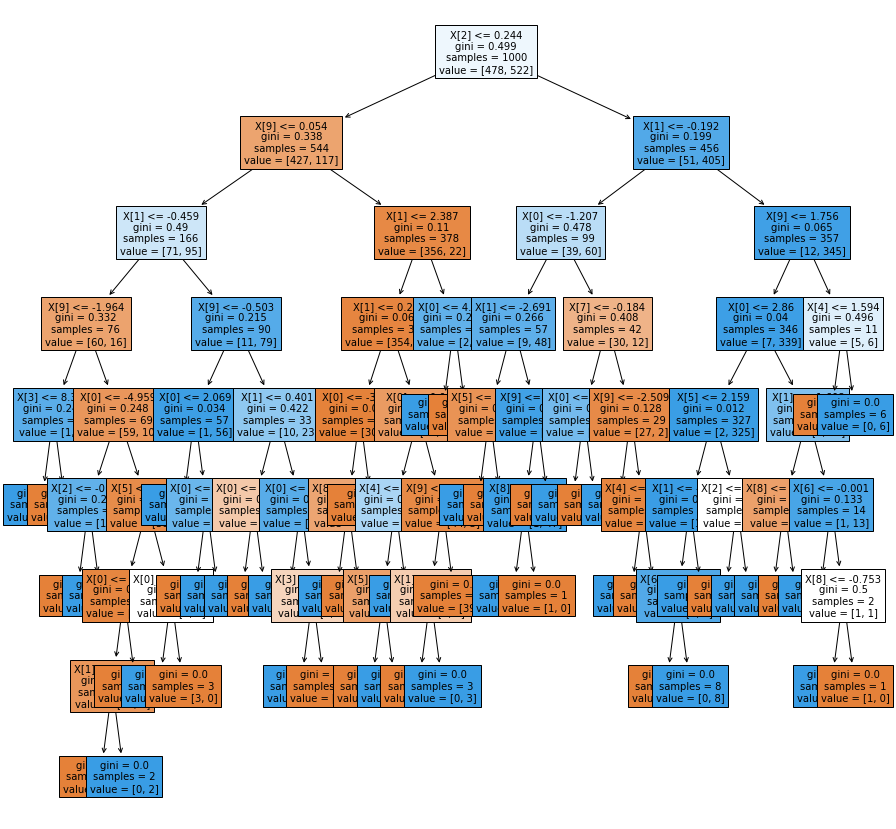

'B'

In [172]:
%matplotlib inline
model = DecisionTreeClassifier()
model.fit(features, datums)
predictions = model.predict([rand_inputs])
plt.figure(figsize=(15, 15))
sklearn.tree.plot_tree(model, fontsize=10, filled=True)
plt.show()
predictions[0]

#### The first 3 layers of both models are very similar and both models produce 9 layers

#### This compares the output from the current model and the sklearn model for 100 different inputs

In [173]:
score = 0

for i in range(100):
    
    rand_inputs = zeros(shape=(1, 10))[0]
    for i in range(10):
        diff = abs(max(features[:, i]) - min(features[:, i]))
        rand_inputs[i] = min(features[:, i]) + diff*np.random.rand()

    ans1 = c.predict(rand_inputs)

    model = DecisionTreeClassifier()
    model.fit(features, datums)
    predictions = model.predict([rand_inputs])
    ans2 = predictions[0]
    
    if ans1 == ans2:
        score += 1

score

74

#### The models are in agreement about 70% of the time. Decreasing the maximum allowable entropy of a decision node or the increment by which the data is split does not change this number significantly. Hence the difference is believed to be from the nature of the data. 